# Assignment - Part 2

Alexandre Vilhena da Costa \
Tiago Marques Claro

## Data Organization

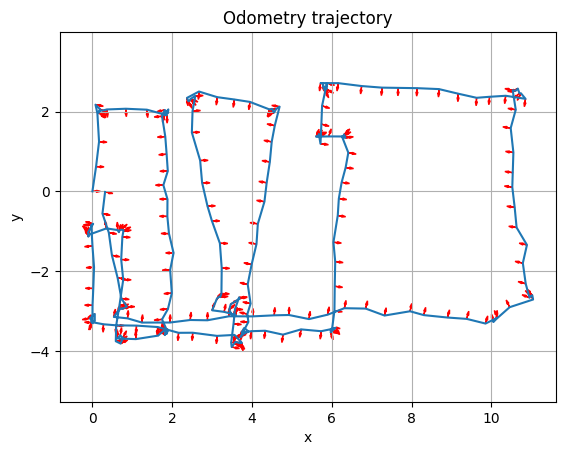

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
data = np.loadtxt('data_slam.txt')

# Extract the robots pose variations delta_x, delta_y, delta_theta (noisy measurements) and the lidar measurements
pose = data[:, 0:3]
lidar = data[:, 3:]

# Initialize arrays for real positions
x = [0]  # Start at origin (x0)
y = [0]  # Start at origin (y0)
theta = [0]  # Start with initial orientation (theta0)

# Calculate real positions
for i in range(len(pose)):
	x.append(x[i] + pose[i, 0])
	y.append(y[i] + pose[i, 1])
	theta.append(theta[i] + pose[i, 2])

# Convert lists to numpy arrays for easier handling
x = np.array(x[:-1])
y = np.array(y[:-1])
theta = np.array(theta[:-1])

# Plot the real trajectory with an arrow indicating the theta direction
plt.figure()
plt.plot(x, y)

for i in range(0, len(x)):
	plt.arrow(x[i], y[i], 0.1*np.cos(theta[i]), 0.1*np.sin(theta[i]), head_width=0.05, head_length=0.1, fc='r', ec='r')

plt.title('Odometry trajectory')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.grid()
plt.show()

## Plot the map captured by the LiDAR

lines:  10
0.9999769913964794
0.9984291801605156
0.9996459340166963
0.9944153811493794
0.9984014982515479
0.9955894485263844
0.9999372441708473
0.999999994563638
0.9999239921987918
0.9987862791076363
0.999803433176531
0.9936765848130675
0.997995123379377
0.9949301274737195
0.999838240640984
0.9999776932979598
0.9999846213837441
0.999566493831972
0.9869402756369108
0.9936664997303133
0.9887691422183704
0.9977388364064658
0.9984350169372174
0.9990440775514213
0.9912551235549495
0.996544106463843
0.9927406216114385
0.9992851059681742
0.9996487031021386
0.9998980140364252
0.9987906973629779
0.9999306333424665
0.995535308747243
0.9944043711560027
0.9930386087537237
0.9993004885164686
0.9989720314311016
0.9983955994076059
0.9976287708435756
0.9965780046993443
0.9955796605829832
0.9943570835755745
0.9999360705692435
0.9997231165342906
0.9999252723603347


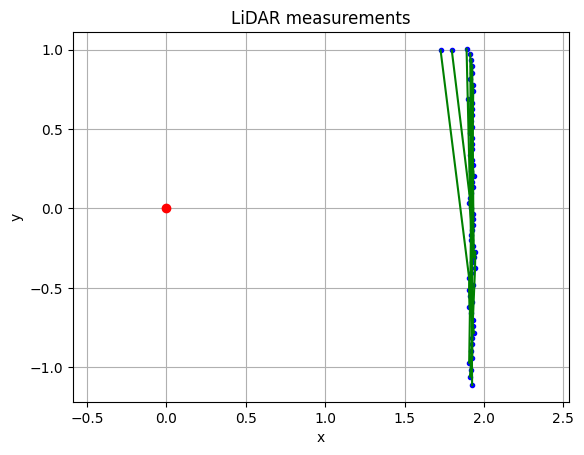

lines:  6
0.9999996379978221
0.9999994205286427
0.9999162505130951
0.9999265874844836
0.971244329425293
0.9999981425140226
0.9999048765075202
0.9999159154147584
0.9710413950517985
0.9999296035534524
0.999939052422449
0.9715000750528929
0.9999996596728751
0.9742442525702356
0.9740578833934532


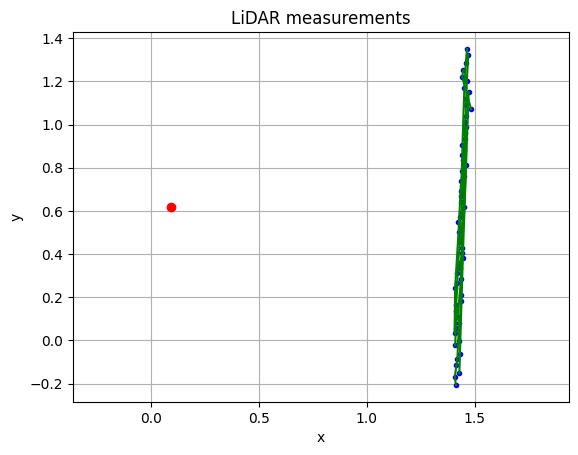

lines:  4
0.9998094357258982
0.9992456837876309
0.9996577965695587
0.9998133603911682
0.9999779613027641
0.9999195890468225


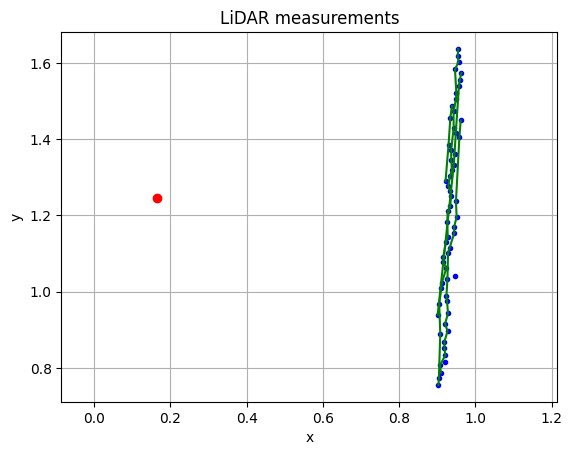

lines:  3
0.9981557876490278
0.9958444110854636
0.9884794586007878


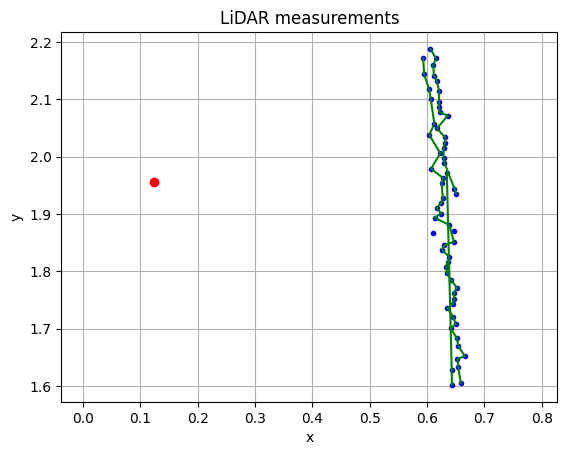

lines:  2
0.9979475875948927


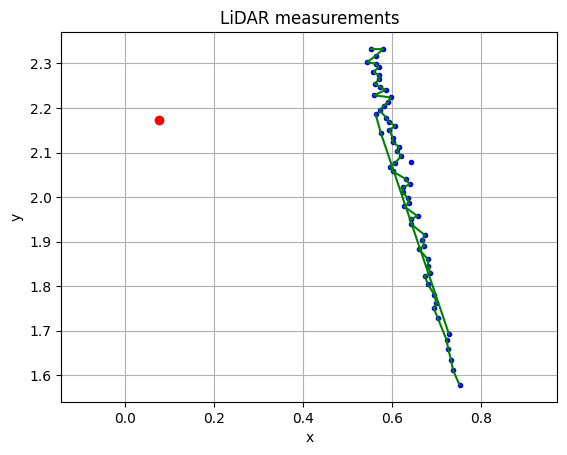

lines:  1


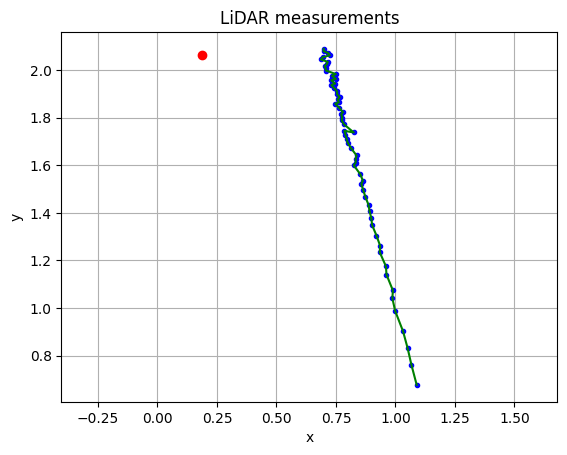

lines:  2
0.006548395756599355


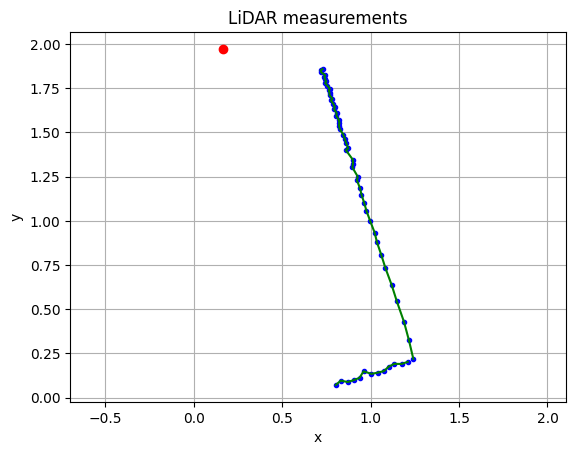

lines:  2
0.1313433309380253


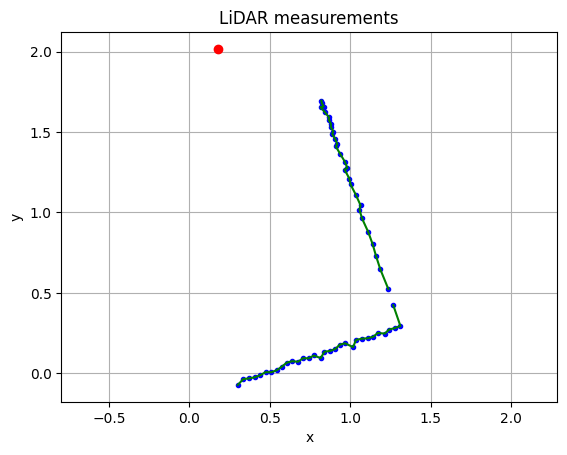

lines:  2
0.03817101088004562


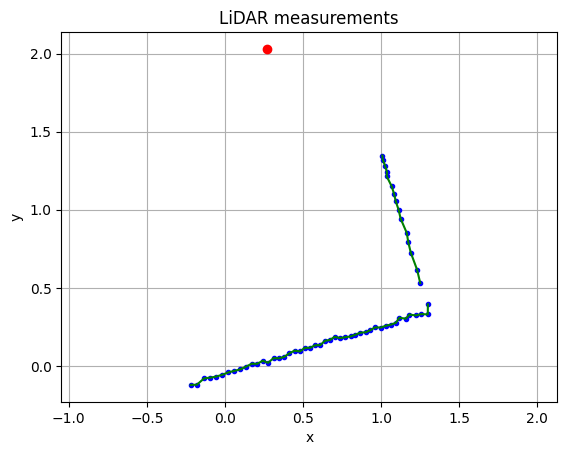

lines:  2
0.07162364426041565


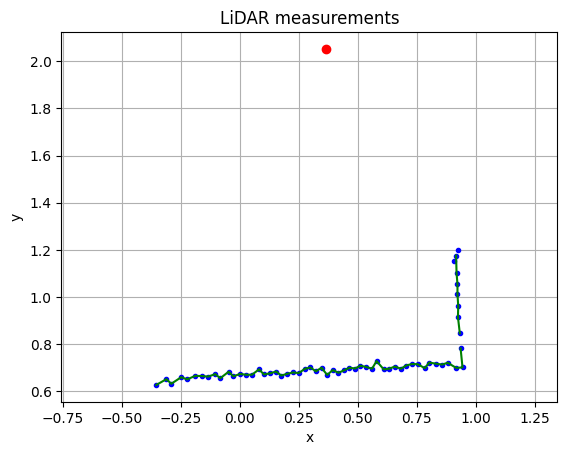

lines:  1


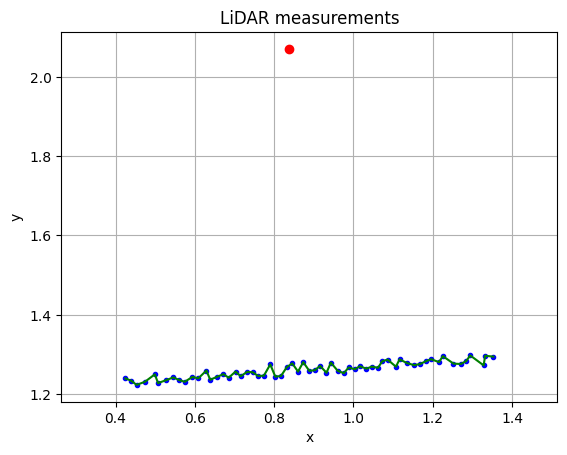

lines:  1


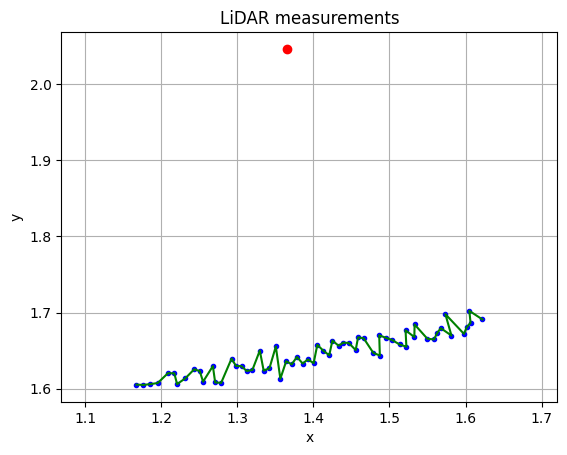

lines:  1


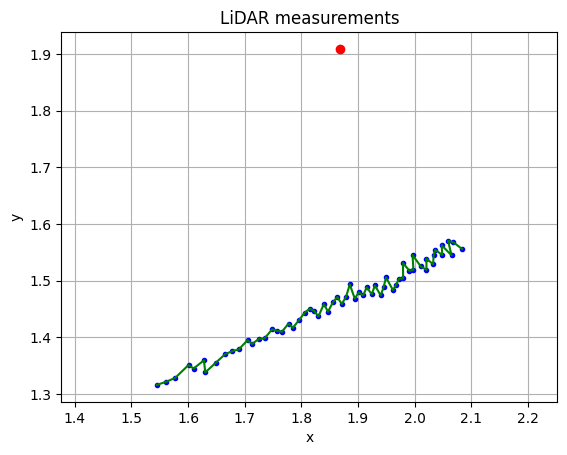

lines:  1


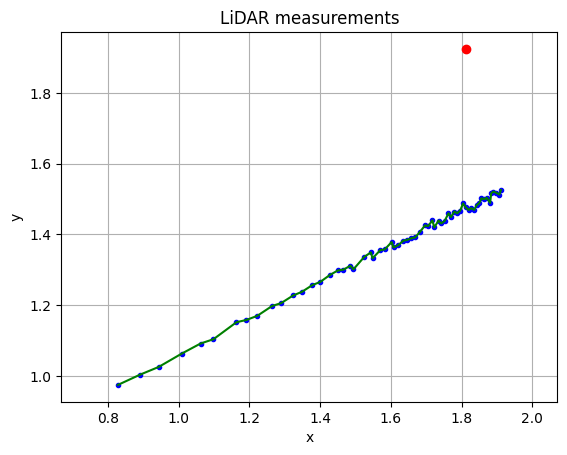

lines:  2
0.005866796169079723


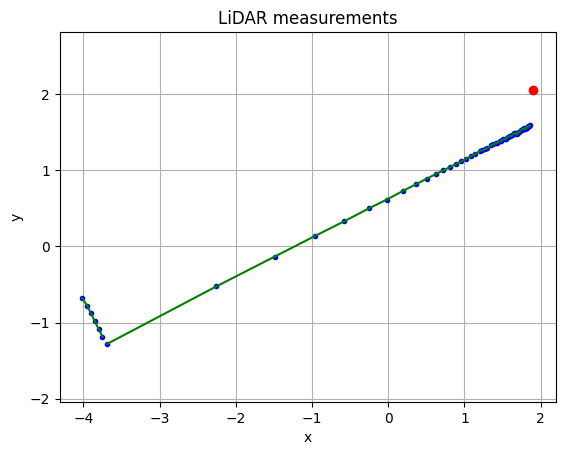

lines:  4
-0.997868977767842
0.007804353799601335
-0.03532574116214325
0.057459835971841226
0.100459281456251
0.9990697212178093


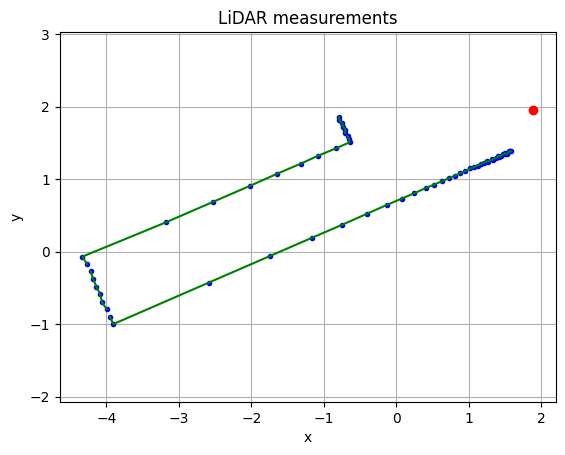

lines:  4
0.00994980214942339
-0.9996111851097241
0.04267678429031411
0.017935989555167127
0.999464101169856
-0.014802291222878067


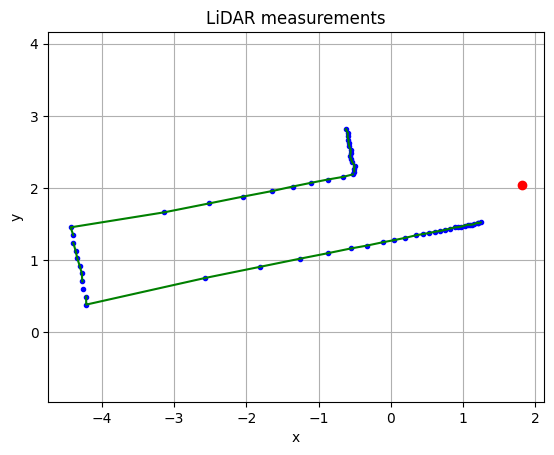

lines:  5
-0.9931086156065448
-0.9668766310607998
-0.9761069620749441
0.2495376561700121
0.9901275154699505
0.994846169075099
-0.13432793047563543
0.9992371636570078
0.005897405332008558
-0.03315882481842546


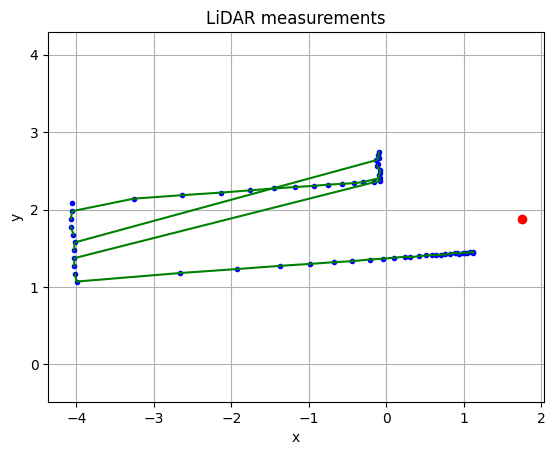

lines:  4
-0.9982764654064785
-0.9738297061743727
-0.0059419141665862235
0.9854894678870192
0.06461708026164077
0.2330613112692194


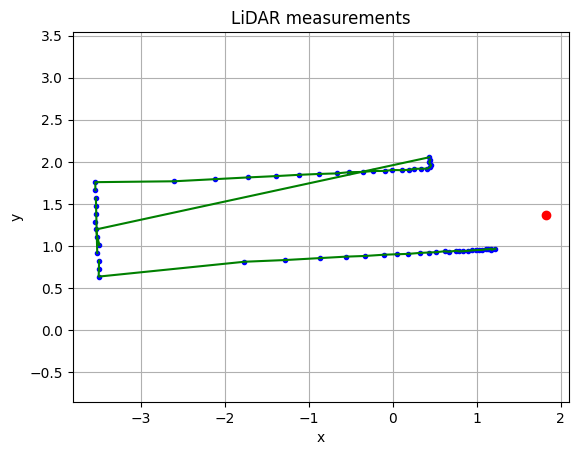

lines:  4
-0.9969610797874325
0.028881522006859922
0.18375550171098398
0.049075003581568334
-0.10662233333931759
0.9878690648578504


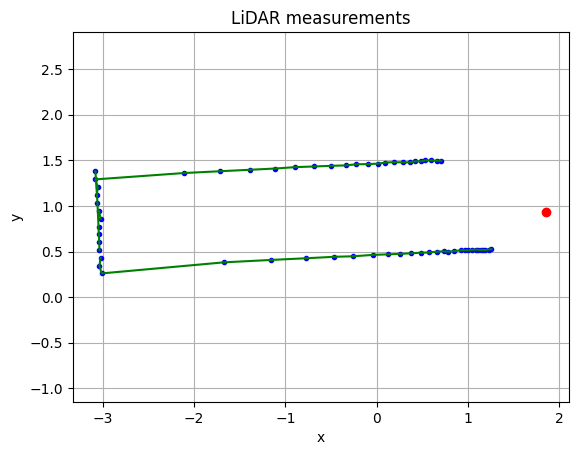

lines:  5
-0.9965390896126806
0.035733250602174596
0.2874279070899278
0.11117582085373275
0.047462796671822065
-0.20681538569470878
-0.02818090192586462
0.9674613210354334
0.9971387491030496
0.9838196558403562


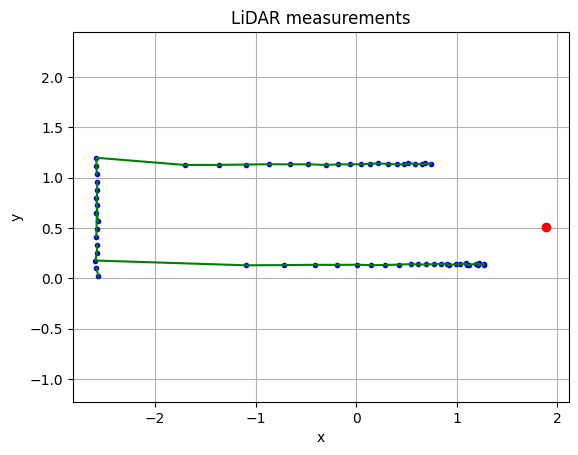

lines:  5
-0.9990391760901716
0.008962730346137529
0.02719858576010431
-0.09030249121890327
0.0348701935100141
0.01663740640921061
0.13386274249080457
0.9998336724099532
0.9950650250609085
0.9930898453670126


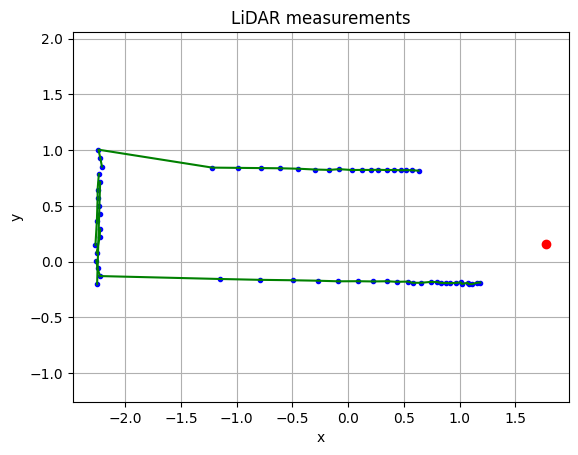

lines:  5
-0.9998498930083153
0.01465701533779609
0.05565590438494683
0.09573934875222782
0.002669357539329134
-0.03834837132656754
-0.07847853189902632
0.9991585050425241
0.9967027648688509
0.9991920270823044


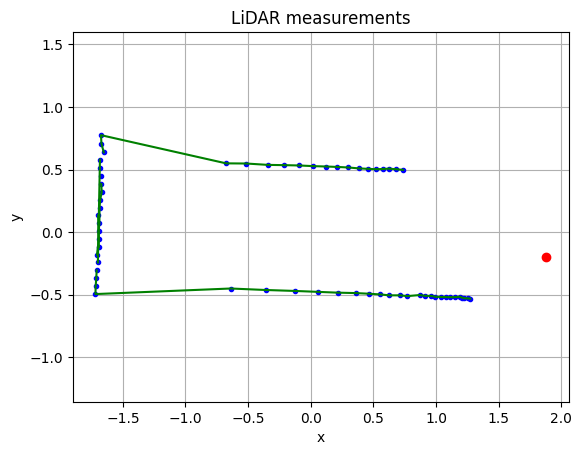

lines:  5
-0.998259081252448
0.005881507286742895
0.008299019220099863
0.11778229205238493
0.053109121542306244
0.05069480728633077
-0.05900637646790567
0.9999970776711149
0.9937150027363952
0.9939827209061605


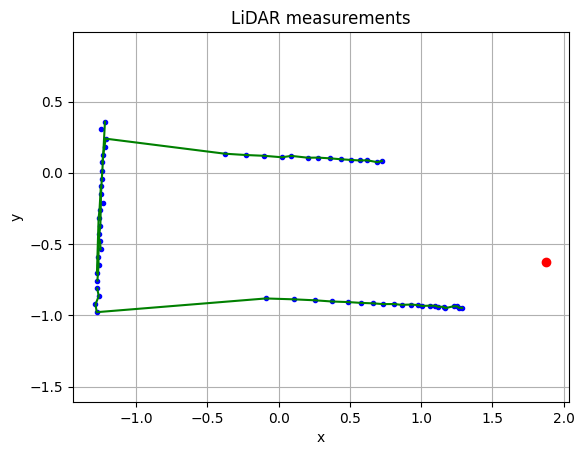

lines:  6
-0.9745944321294997
0.12649395702599434
0.14674041378421013
0.13179895364885147
0.21892413971916083
0.09889756306643027
0.07854005859861317
0.09357259495040827
0.00518148397568635
0.9997911419064536
0.999985689827097
0.9955966973112189
0.9998861683755532
0.9973045300531037
0.9960839393025719


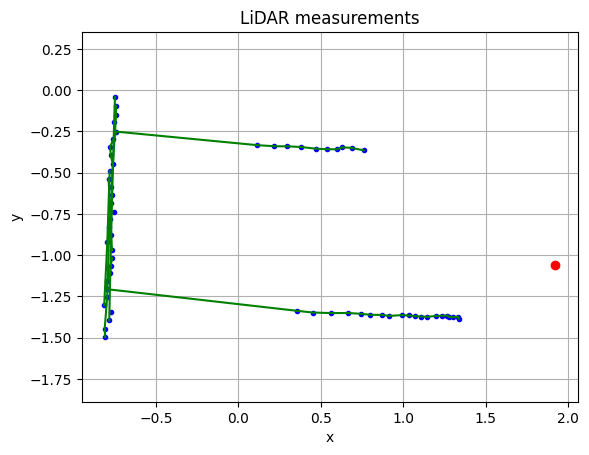

lines:  7
0.17539137548822295
-0.8568994832344587
0.136504969200906
0.25132801390489895
0.15026343599135794
0.19061720919018296
0.3572001376425669
0.9992250702359442
0.9969790863242485
0.9996756936768312
0.9998800702369288
0.3936872558595598
0.2835746860907772
0.38087007151554664
0.3426920701890128
0.9931493392252185
0.9999033654880028
0.9984956579435957
0.9946778183602031
0.998062396299451
0.9991614154761819


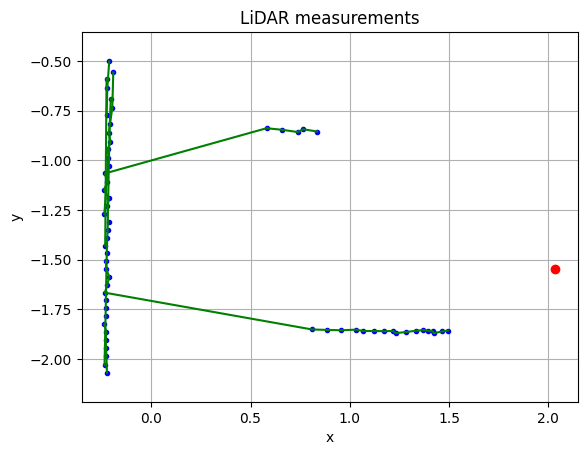

lines:  8
0.137941174051953
0.9999981347298622
0.9999973598781365
0.9979802424312914
0.989392178062857
0.9999344638325907
0.9960945689790395
0.13985391257499327
0.14021671971906943
0.07474475974665232
-0.007402492693558377
0.12659308159055377
0.04995374590206447
0.9999999328690576
0.9978556847940074
0.9891097511147573
0.9999104863771402
0.9959221771006153
0.9978316348498493
0.9890557554329088
0.9999055166550579
0.9958890533266529
0.9966220782764498
0.9986421051910259
0.9996915033724292
0.9909904499285579
0.9983543854424806
0.997040107870105


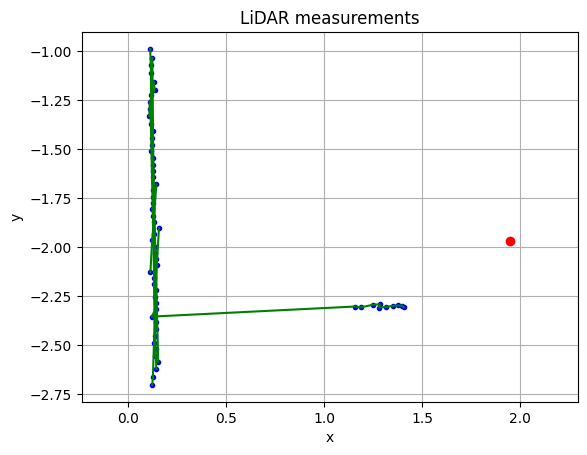

lines:  5
0.9999999960797288
0.9999994867103956
0.9999992061929737
0.9995365376178585
0.9999993930742642
0.9999993138421931
0.9995338381644097
0.9999974162634543
0.9995668683814226
0.999497387208285


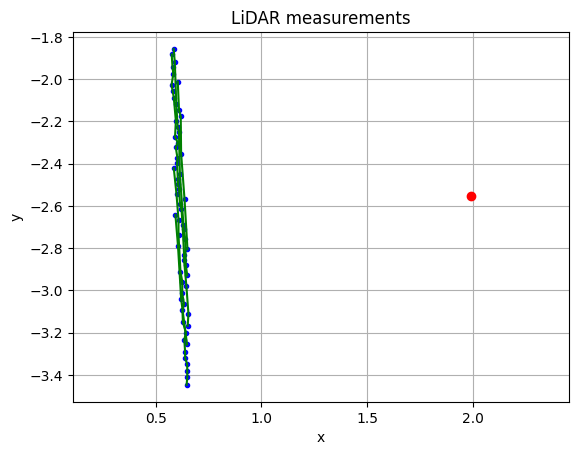

lines:  6
0.9998846813790607
0.9997624769561794
0.9994761821198972
0.9938403091194693
0.9995894281697356
0.999316211420546
0.999852397821387
0.9954086726368522
0.9999092850524335
0.9985334567377345
0.9911889733579321
0.9987275391259854
0.9969062350273397
0.9999931104242015
0.9966076019048391


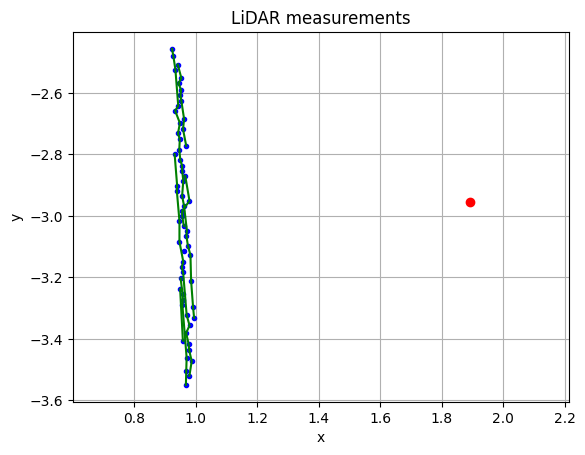

lines:  2
0.9999444733205926


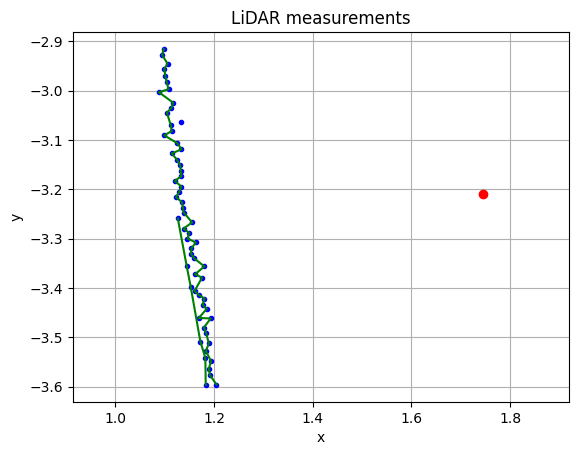

lines:  1


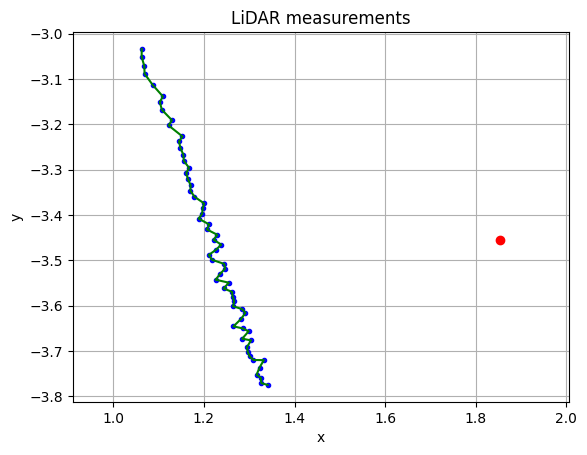

lines:  1


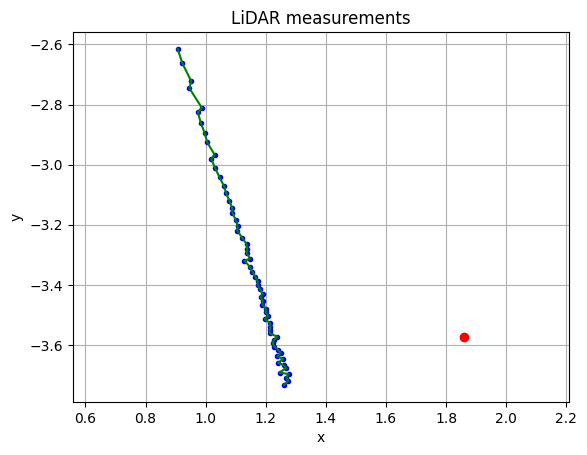

lines:  1


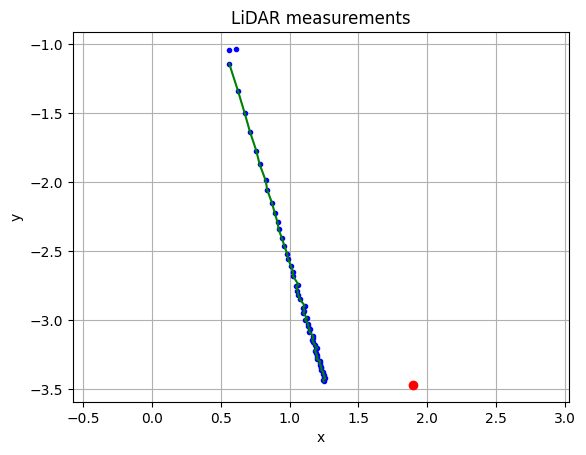

lines:  2
0.02003693621081717


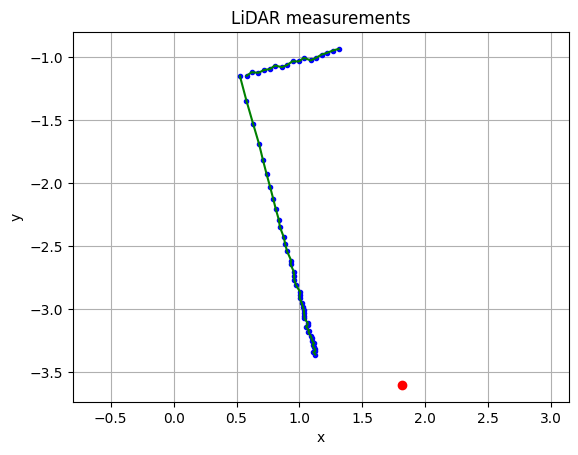

lines:  3
perpendicular
-0.9636437945311426
0.26722898794573136


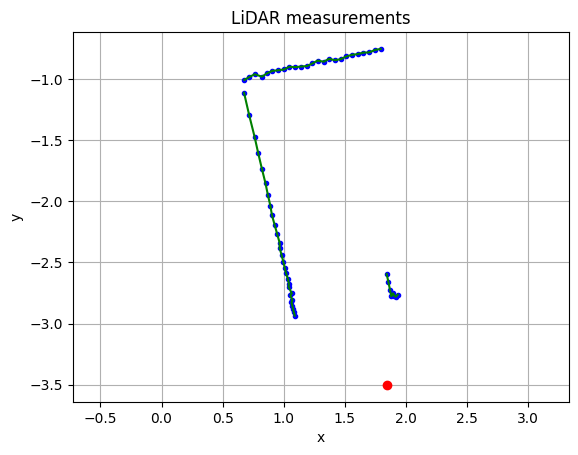

lines:  3
0.6649029143123041
-0.00826057902540799
-0.7523967906893129


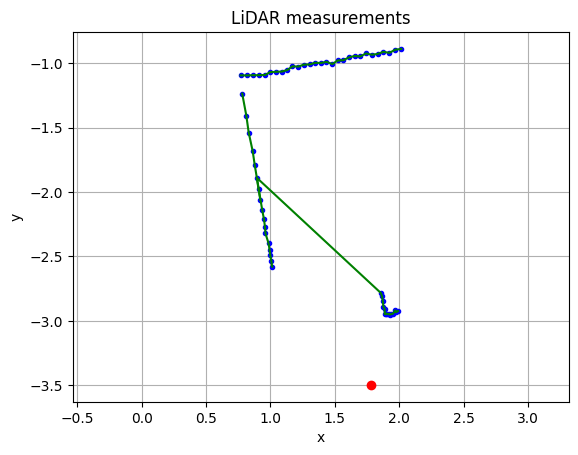

lines:  5
0.0599535671403166
-0.03619493713866023
0.04067174130817971
0.04436109110080332
0.9953770786730289
0.9998136337917686
0.9998781057256704
0.9970457420482343
0.996755308975316
0.999993182024528


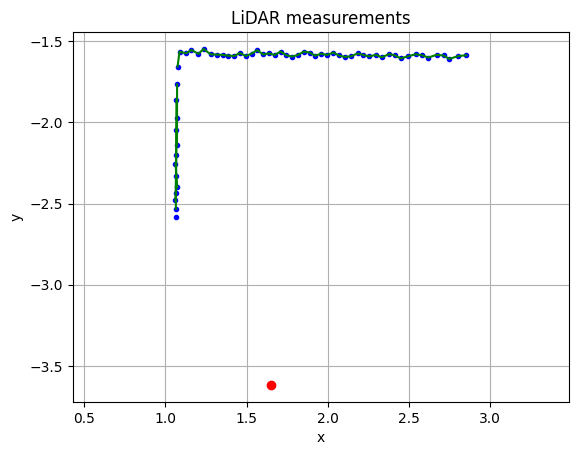

lines:  2
0.027294044443928814


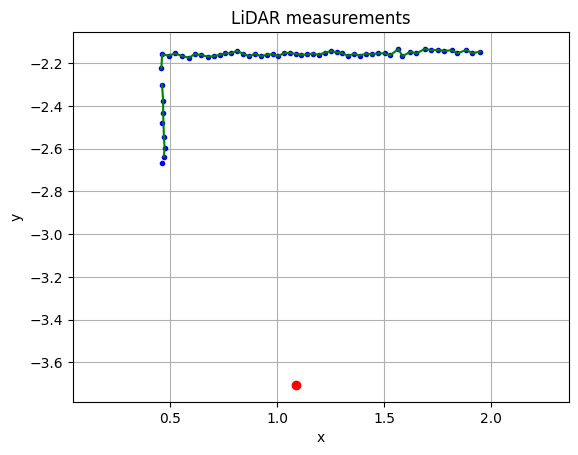

lines:  1


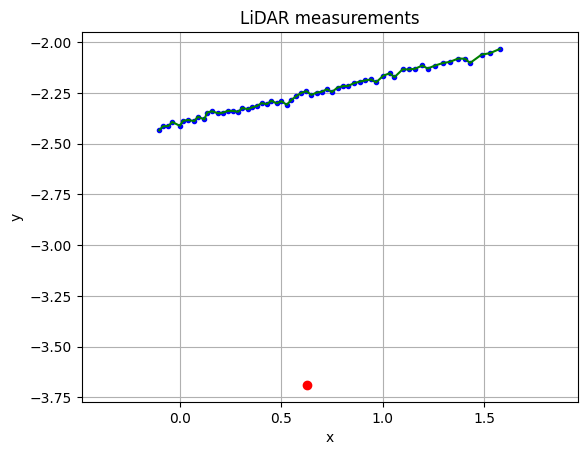

lines:  1


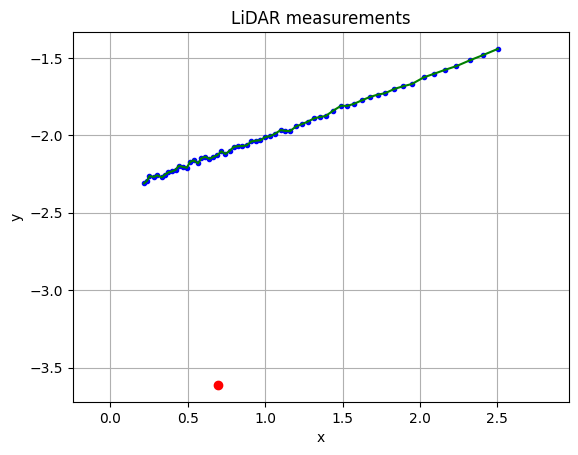

lines:  2
0.06687991511078414


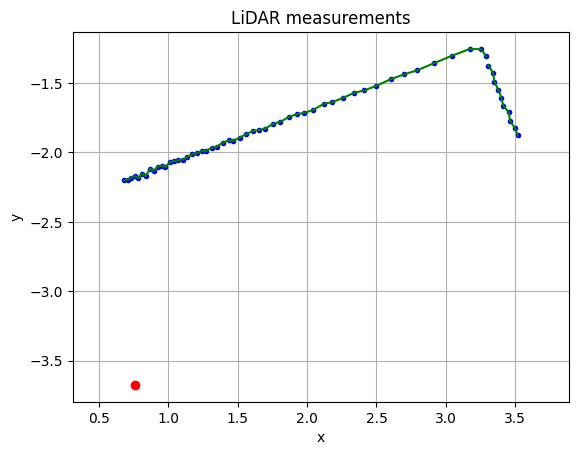

lines:  2
0.0348914680531724


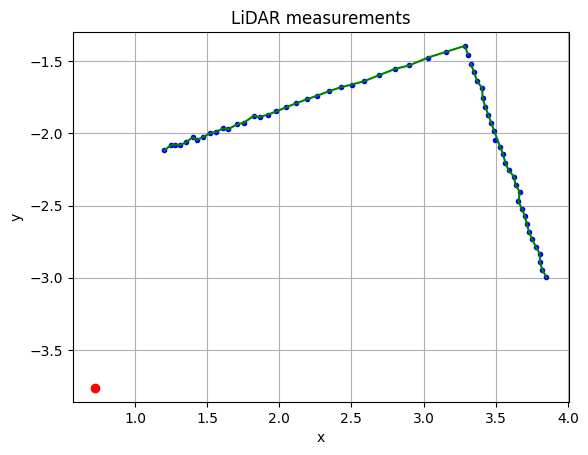

lines:  3
0.009597108172636178
-0.001918174491819265
-0.9999705160113416


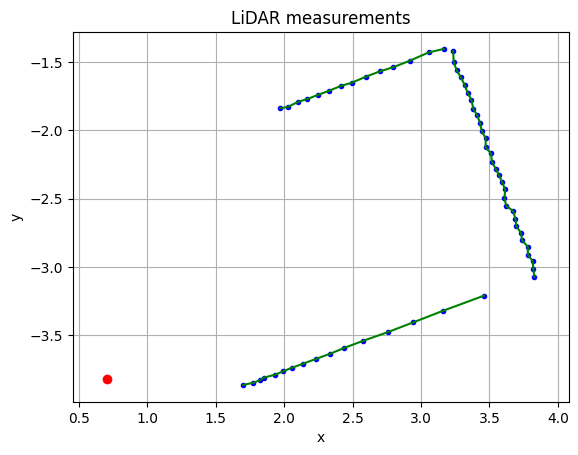

lines:  3
-0.018229551477348793
-0.013290132218110831
-0.9995032517392176


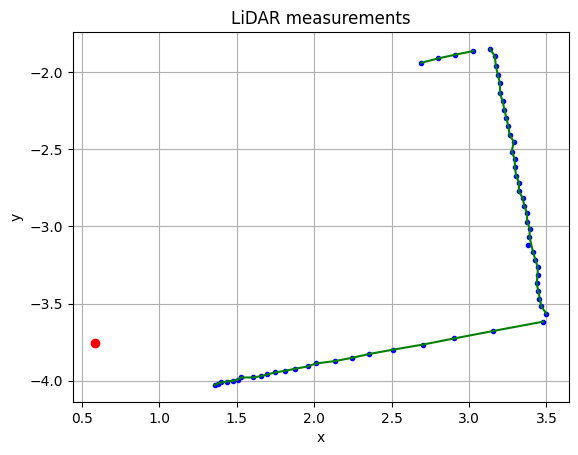

lines:  6
0.09403186752875084
0.09046912579988396
0.09563716825246421
0.24090661349773845
0.08315064731843134
0.9999935989616898
0.9999986998114282
0.9889008820948249
0.9999403312041681
0.999986529024145
0.988362945558016
0.9999730165877967
0.9891391864166378
0.9999214153818455
0.9872188216097888


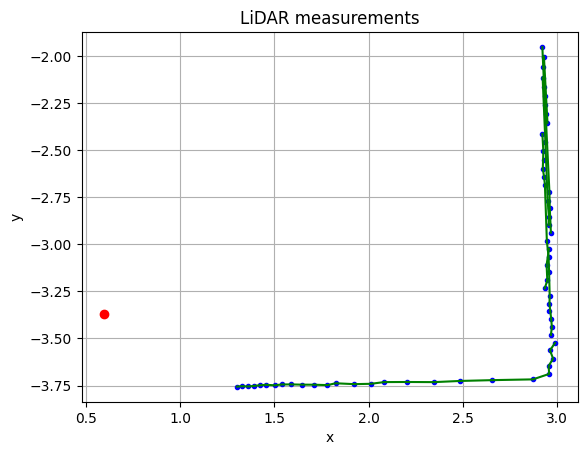

lines:  7
0.10402402386732301
0.10661331227281619
0.07868422704117596
0.08380882010565813
0.05053522117102068
0.06064117891356863
0.9999966101928984
0.9996762449888253
0.9997938543153932
0.9985608731370115
0.9990525388232994
0.9996066056181825
0.9997375985486073
0.9984178480434692
0.9989358352618584
0.9999867820205344
0.9996021556357735
0.9998364303563618
0.9994439240497889
0.9997302227311621
0.9999487765219941


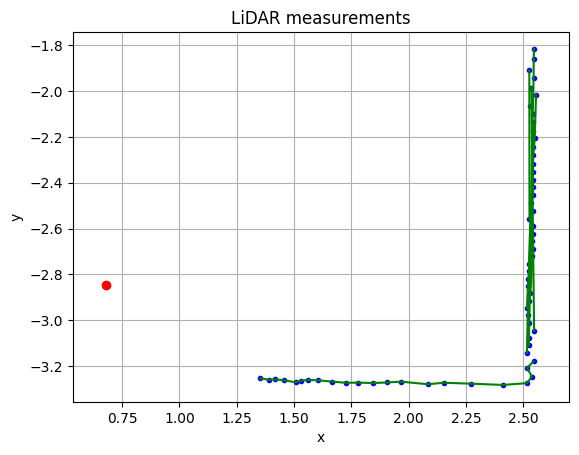

lines:  7
0.27813046878065356
0.2638188547767622
0.2186468846066782
0.21590077695987975
0.2362624036449075
0.352663670686596
0.9998894726850728
0.9981144064826971
0.9979377724945869
0.9990614160772557
0.9969150505153643
0.9989166698344941
0.998781799809325
0.9995949948199496
0.9956379427011934
0.9999960426266726
0.9998363811290011
0.9902175929889165
0.9997815344551241
0.9898211277247608
0.9925795614669053


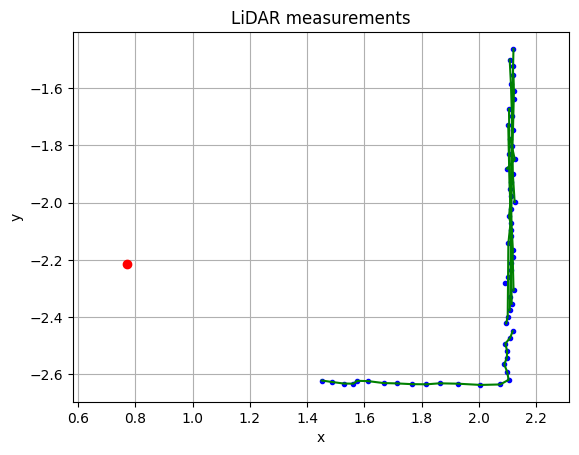

lines:  5
0.9999603186306006
0.9996160501124279
0.9376536748848919
0.9953667353542601
0.9993295445148453
0.9345201354886629
0.9944706755850019
0.9469242793242898
0.9976487562672547
0.9667286601183996


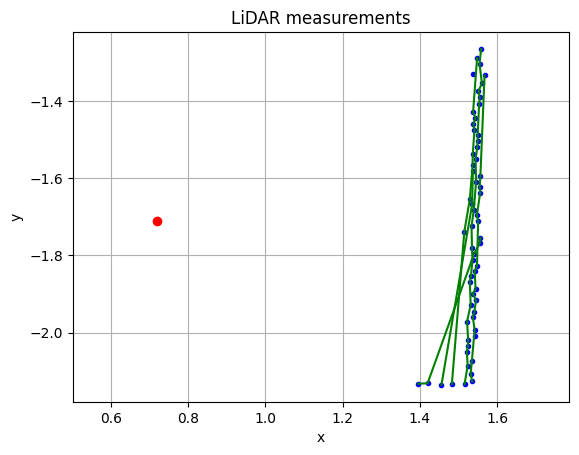

lines:  1


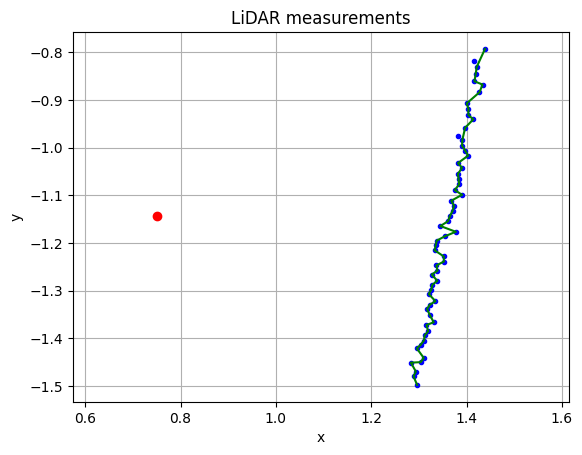

lines:  1


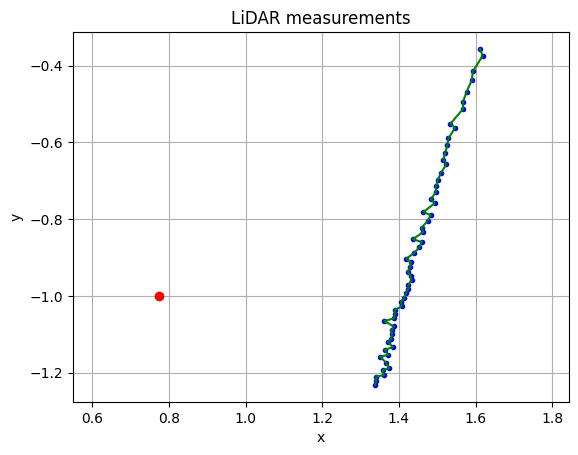

lines:  2
-0.13518330812075818


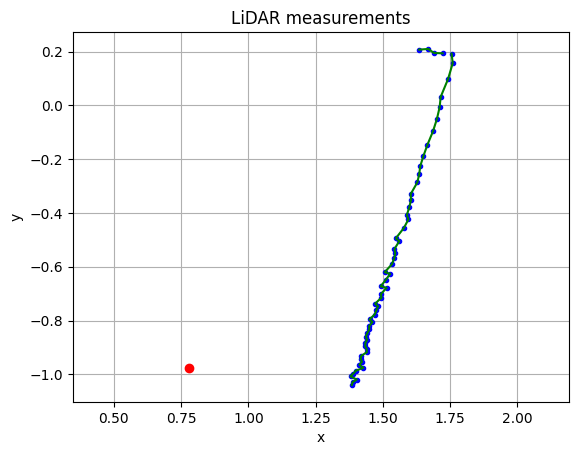

lines:  2
-0.035909730302291276


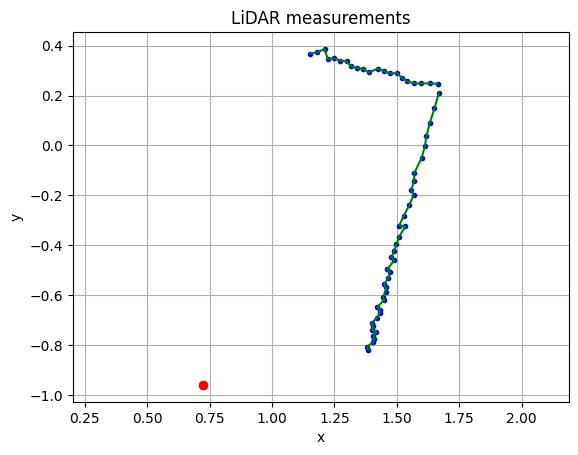

lines:  2
0.11001341840712883


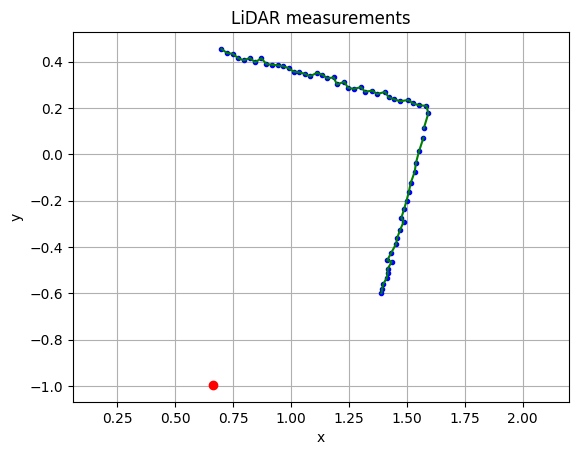

lines:  2
0.09491872980903879


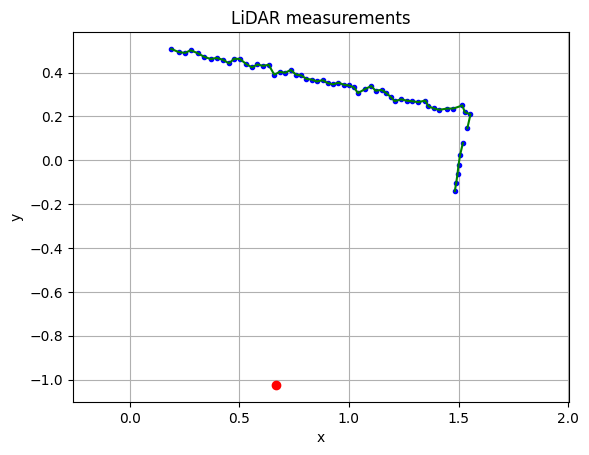

lines:  1


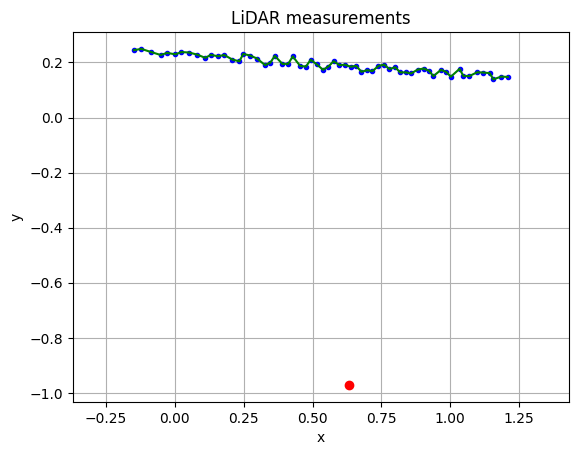

lines:  1


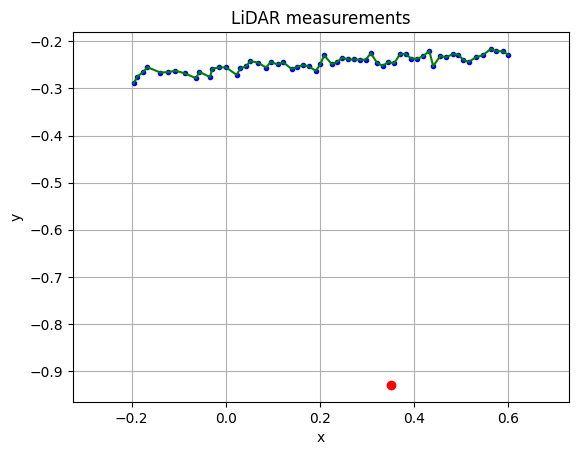

lines:  1


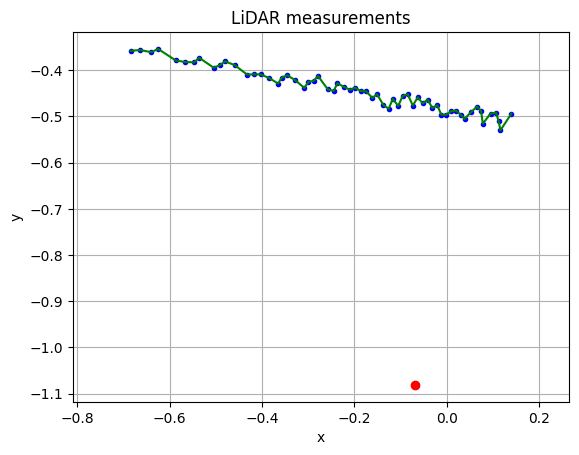

lines:  2
0.9997608704144444


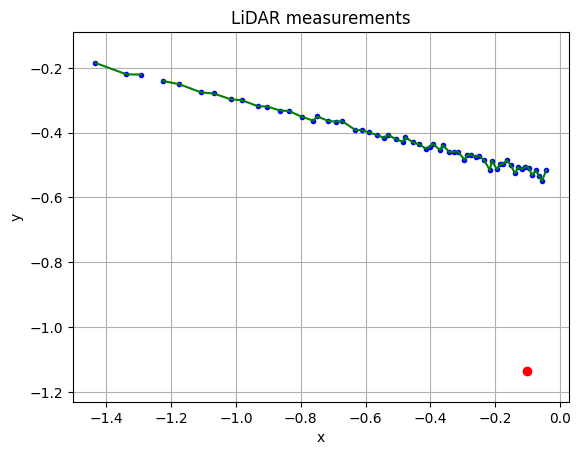

lines:  2
-0.013446796106219296


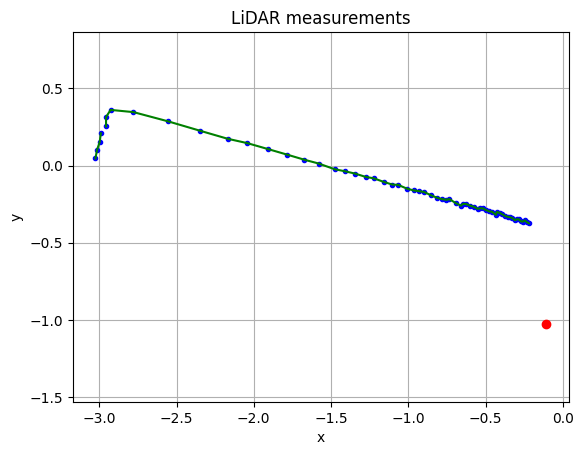

lines:  3
0.08634110958037947
0.10600565432202178
0.9998048476373748


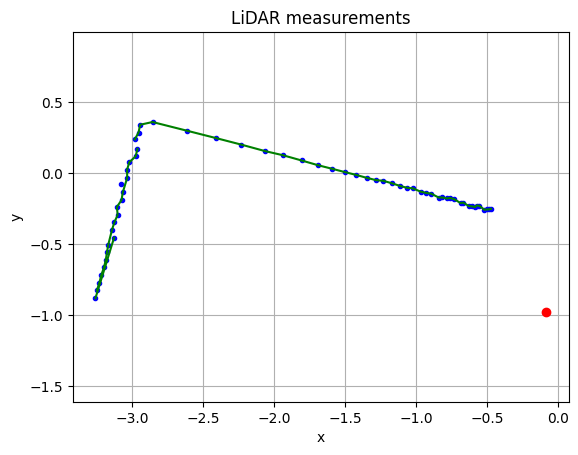

lines:  3
0.00964954545266714
0.034185006530174894
-0.9990391213471634


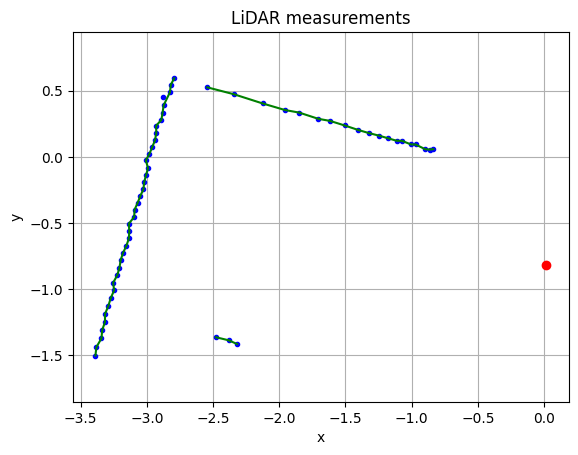

lines:  9
0.040528089214828845
-0.0013188328554903635
0.03784915418734439
0.005160431394210666
0.04518994042898922
0.08390935906313925
-0.06055478669882126
0.3875003603554543
0.9991240807570474
0.999996406134277
0.9993742377274927
0.999989113574297
0.9990553741784055
0.9948906124826415
0.9368167925729649
0.9992326783063883
0.9999790094899467
0.9989179460716608
0.9963618622330634
0.998243868639924
0.9213577019819955
0.9994654764413067
0.9999730099005508
0.9989352805088134
0.9951577065883723
0.9358755601154435
0.9991983108969404
0.9968931315793998
0.997839095559977
0.9238569461282097
0.9992472657437695
0.9944086954204894
0.9384388999887231
0.9895636247358837
0.9511333855447367
0.8967128044310455


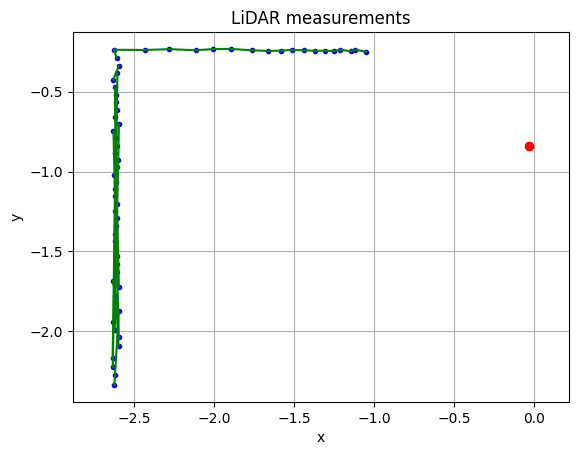

lines:  5
0.08373550599549423
0.9999905070996283
0.999987891270818
0.9999958007416778
0.0880766680066813
0.08863831799912207
0.0866229929722112
0.9999998410335847
0.9999989352907186
0.9999979535172915


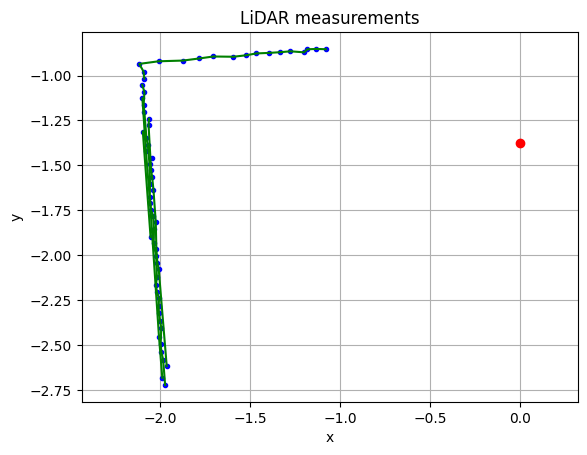

lines:  6
0.3929846366727142
0.9997889073242539
0.9999884463014561
0.9997446262836484
0.9996438172180931
0.3740086482923552
0.3885598418566907
0.3721041433578495
0.4173852968500679
0.999876121030781
0.9999978932285176
0.9988844704424786
0.9998417054974275
0.9995039793370554
0.9987854360970788


KeyboardInterrupt: 

In [ ]:
from sklearn.linear_model import RANSACRegressor
from sklearn.cluster import DBSCAN

# Function to calculate intersection of two lines
def compute_intersection(line1, line2):
    m1, b1 = line1
    m2, b2 = line2
    if abs(m1 - m2) < 1e-6:  # Parallel lines
        return None
    x = (b2 - b1) / (m1 - m2)
    y = m1 * x + b1
    return x, y

# Function to merge collinear lines
def merge_lines(lines):
    merged = []
    for i in range(len(lines) - 1):
        m1, b1 = lines[i]
        m2, b2 = lines[i + 1]
        if abs(m1 - m2) < 1e-2:  # Similar slopes -> merge
            x_vals = np.linspace(-10, 10, 100)
            y_vals = m1 * x_vals + (b1 + b2) / 2
            merged.append((m1, (b1 + b2) / 2))
        else:
            merged.append(lines[i])
    merged.append(lines[-1])
    return merged

# LiDAR FoV (-30 to 30 degrees) in radians
lidar_angles = np.linspace(-30, 30, lidar.shape[1]) * np.pi / 180 # 61 measurements in this range

# Plot the LiDAR measurements for all the poses in the global frame
for i in range(len(lidar)):
	x_points = []
	y_points = []
	corners = []
	#print("position: ", x[i], y[i])
	for j in range(len(lidar_angles)):
		#print("distances: ", lidar[i, j])
		x_global = x[i] + lidar[i, j]*np.cos(theta[i] + lidar_angles[j])
		y_global = y[i] + lidar[i, j]*np.sin(theta[i] + lidar_angles[j])
		x_points.append(x_global)
		y_points.append(y_global)

	# Combine points into an array
	points = np.column_stack((x_points, y_points))

	# DBSCAN clustering to group points spatially
	clustering = DBSCAN(eps=0.2, min_samples=5).fit(points)
	clusters = [points[clustering.labels_ == k] for k in np.unique(clustering.labels_) if k != -1]

# Plot the LiDAR measurements for all poses in the global frame
for i in range(len(lidar)):
    x_points = []
    y_points = []
    corners = []

    # Convert LiDAR distances to global coordinates
    for j in range(len(lidar_angles)):
        x_global = x[i] + lidar[i, j] * np.cos(theta[i] + lidar_angles[j])
        y_global = y[i] + lidar[i, j] * np.sin(theta[i] + lidar_angles[j])
        x_points.append(x_global)
        y_points.append(y_global)

    # Combine points into an array
    points = np.column_stack((x_points, y_points))

    # DBSCAN clustering to group points spatially
    clustering = DBSCAN(eps=0.2, min_samples=5).fit(points)
    clusters = [points[clustering.labels_ == k] for k in np.unique(clustering.labels_) if k != -1]

    plt.figure()

    # Show centroid of each cluster
    for cluster in clusters:
      centroid = np.mean(cluster, axis=0)  # Calculate centroid
      plt.scatter(centroid[0], centroid[1], marker='x', color='red', s=100)  # Plot centroid











